In [610]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import seaborn
import squarify

In [952]:
# Permanently changes the pandas settings
#pandas.set_option('display.max_rows', 100)
#pandas.set_option('display.max_columns', None)
#pandas.set_option('display.width', None)
#pandas.set_option('display.max_colwidth', -1)

In [612]:
pandas.__version__

'2.1.1'

## colors

In [613]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/1445812906.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('Reds')


## import terminals data from sheet

In [614]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1fNf3eK_nqgzXX6ijGlg9A4MPXAF4fh9ZmH3XnsrvS9A') # copy for 2022 report
#spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
spreadsheet = gc.open_by_key('1il2duWGhw5WTnlHBqzdM7b3VXCufecO9e4kGPkgy9f8') # copy for 2023 report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')


In [615]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [616]:
multiindex_region_subregion

MultiIndex([(  'Africa',                 'Northern Africa'),
            (  'Africa',              'Sub-Saharan Africa'),
            ('Americas', 'Latin America and the Caribbean'),
            ('Americas',                'Northern America'),
            (    'Asia',                    'Central Asia'),
            (    'Asia',                    'Eastern Asia'),
            (    'Asia',              'South-eastern Asia'),
            (    'Asia',                   'Southern Asia'),
            (    'Asia',                    'Western Asia'),
            (  'Europe',                  'Eastern Europe'),
            (  'Europe',                 'Northern Europe'),
            (  'Europe',                 'Southern Europe'),
            (  'Europe',                  'Western Europe'),
            ( 'Oceania',       'Australia and New Zealand'),
            ( 'Oceania',                       'Melanesia'),
            ( 'Oceania',                      'Micronesia'),
            ( 'Oceania',

In [617]:
multiindex_region_subregion_country

MultiIndex([( 'Africa',    'Northern Africa',           'Algeria'),
            ( 'Africa',    'Northern Africa',    'Canary Islands'),
            ( 'Africa',    'Northern Africa',             'Egypt'),
            ( 'Africa',    'Northern Africa',             'Libya'),
            ( 'Africa',    'Northern Africa',           'Morocco'),
            ( 'Africa',    'Northern Africa',             'Sudan'),
            ( 'Africa',    'Northern Africa',           'Tunisia'),
            ( 'Africa',    'Northern Africa',    'Western Sahara'),
            ( 'Africa', 'Sub-Saharan Africa',            'Angola'),
            ( 'Africa', 'Sub-Saharan Africa',             'Benin'),
            ...
            ('Oceania',          'Polynesia',    'American Samoa'),
            ('Oceania',          'Polynesia',      'Cook Islands'),
            ('Oceania',          'Polynesia',  'French Polynesia'),
            ('Oceania',          'Polynesia',              'Niue'),
            ('Oceania',         

In [618]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [619]:
status_list = ['Proposed', 
               'Construction', 
               'Shelved', 
               'Cancelled', 
               'Operating', 
               'Idle', 
               'Mothballed', 
               'Retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

## table for exports

In [620]:
#mtpa by country

mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['FacilityType']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['FacilityType']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby(['Region','SubRegion'])['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_region_df.index.names = ['Region','Subregion']
mtpa_by_region_df.sort_index(level='Region', inplace=True)

mtpa_by_region_df.to_excel('global-export-capacity-totals.xlsx')
mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]

# total
mtpa_by_region_df.loc['Total',:] = mtpa_by_region_df.sum(axis=0).values
mtpa_by_country_df.loc['Total',:] = mtpa_by_country_df.sum(axis=0).values

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

# mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]
mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df

Proposed  Construction  \
Region   Subregion                                                 
Africa   Northern Africa                      0.00          0.07   
         Sub-Saharan Africa                  79.65         13.52   
Americas Latin America and the Caribbean     89.56          7.45   
         Northern America                   322.58         90.11   
Asia     Central Asia                         0.00          0.00   
         South-eastern Asia                  16.70          0.00   
         Southern Asia                        0.00         10.80   
         Western Asia                        30.75         33.00   
Europe   Eastern Europe                     131.40         32.70   
         Northern Europe                      0.00          0.00   
Oceania  Australia and New Zealand           21.70          5.00   
         Melanesia                            9.20          0.00   
Total                                       701.54        192.65   

                                          Proposed+Construction  Shelved  \
Region   Subregion                                                         
Africa   Northern Africa                                   0.07      0.0   
         Sub-Saharan Africa                               93.17     32.9   
Americas Latin America and the Caribbean                  97.01      0.0   
         Northern America                                412.69      6.0   
Asia     Central Asia                                      0.00      0.0   
         South-eastern Asia                               16.70      0.0   
         Southern Asia                                    10.80      0.0   
         Western Asia                                     63.75     22.0   
Europe   Eastern Europe                                  164.10     16.2   
         Northern Europe                                   0.00      0.0   
Oceania  Australia and New Zealand                        26.70      7.2   
         Melanesia                                         9.20      1.5   
Total                                                    894.19     85.8   

                                          Cancelled  Operating   Idle  \
Region   Subregion                                                      
Africa   Northern Africa                       5.00      37.54   0.00   
         Sub-Saharan Africa                   27.39      37.72   0.00   
Americas Latin America and the Caribbean      21.60      16.45   0.00   
         Northern America                    460.82      92.92   0.00   
Asia     Central Asia                          0.00       0.20   0.00   
         South-eastern Asia                    2.95      52.55   9.60   
         Southern Asia                        63.95       0.00   0.00   
         Western Asia                         22.64      96.40   0.00   
Europe   Eastern Europe                       16.36      31.06   3.76   
         Northern Europe                       0.00       4.67   0.00   
Oceania  Australia and New Zealand            45.80      87.60   0.00   
         Melanesia                             6.00       8.30   0.00   
Total                                        672.51     465.41  13.36   

                                          Mothballed  Retired  
Region   Subregion                                             
Africa   Northern Africa                        3.20     7.80  
         Sub-Saharan Africa                     0.00     0.00  
Americas Latin America and the Caribbean        3.75     0.00  
         Northern America                       1.50     0.00  
Asia     Central Asia                           0.00     0.00  
         South-eastern Asia                     0.00    30.10  
         Southern Asia                          0.00     0.00  
         Western Asia                           7.20     0.00  
Europe   Eastern Europe                         0.00     0.00  
         Northern Europe                        0.00     0.01  
Oceania  Austral

## table for imports

In [621]:
#mtpa by country

mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['FacilityType']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['FacilityType']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby(['Region','SubRegion'])['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_region_df.index.names = ['Region','Subregion']
mtpa_by_region_df.sort_index(level='Region', inplace=True)

mtpa_by_region_df.to_excel('global-import-capacity-totals.xlsx')
mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]

# total
mtpa_by_region_df.loc['Total',:] = mtpa_by_region_df.sum(axis=0).values
mtpa_by_country_df.loc['Total',:] = mtpa_by_country_df.sum(axis=0).values

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

# mtpa_by_region_df = mtpa_by_region_df.loc[~(mtpa_by_region_df==0).all(axis=1)]
mtpa_by_region_import_df = mtpa_by_region_df.copy()

mtpa_by_region_df

Proposed  Construction  \
Region   Subregion                                                 
Africa   Northern Africa                      0.00          0.00   
         Sub-Saharan Africa                   1.50          1.70   
Americas Latin America and the Caribbean     40.88         16.06   
         Northern America                     0.05          0.00   
Asia     Eastern Asia                       195.15        113.20   
         South-eastern Asia                  38.00          8.60   
         Southern Asia                       67.36         30.00   
         Western Asia                         0.00          2.00   
Europe   Eastern Europe                       7.80          1.54   
         Northern Europe                     34.37          3.80   
         Southern Europe                     45.95          4.04   
         Western Europe                      66.64         19.24   
Oceania  Australia and New Zealand            8.30          2.33   
Total                                       506.00        202.51   

                                          Proposed+Construction  Shelved  \
Region   Subregion                                                         
Africa   Northern Africa                                   0.00     6.15   
         Sub-Saharan Africa                                3.20     0.88   
Americas Latin America and the Caribbean                  56.94    16.28   
         Northern America                                  0.05     0.00   
Asia     Eastern Asia                                    308.35    40.26   
         South-eastern Asia                               46.60    27.90   
         Southern Asia                                    97.36    25.54   
         Western Asia                                      2.00    11.10   
Europe   Eastern Europe                                    9.34     6.00   
         Northern Europe                                  38.17     0.00   
         Southern Europe                                  49.99     2.65   
         Western Europe                                   85.88     0.00   
Oceania  Australia and New Zealand                        10.63     1.00   
Total                                                    708.51   137.76   

                                          Cancelled  Operating  Idle  \
Region   Subregion                                                     
Africa   Northern Africa                      10.64       0.00   5.7   
         Sub-Saharan Africa                    7.70       2.50   0.0   
Americas Latin America and the Caribbean      24.97      77.14   0.0   
         Northern America                    259.52      59.80  25.0   
Asia     Eastern Asia                         52.17     532.35   0.0   
         South-eastern Asia                   35.17      58.15   0.0   
         Southern Asia                        72.45      65.50   0.0   
         Western Asia                          8.00      72.80  22.9   
Europe   Eastern Europe                        7.30       4.58   0.0   
         Northern Europe                      27.16      43.78   0.0   
         Southern Europe                      47.68      79.91   0.0   
         Western Europe                       12.40      72.00   0.0   
Oceania  Australia and New Zealand             1.75       0.00   0.0   
Total                                        566.91    1068.51  53.6   

                                          Mothballed  Retired  
Region   Subregion                                             
Africa   Northern Africa                         4.2      0.0  
         Sub-Saharan Africa                      0.0      0.0  
Americas Latin America and the Caribbean         0.0      0.0  
         Northern America                       45.0     17.3  
Asia     Eastern Asia                            1.5      0.0  
         South-eastern Asia                      0.4      0.0  
         Southern Asia                           0.0      0.0  
       

## stacked bar charts for FacilityType capacity

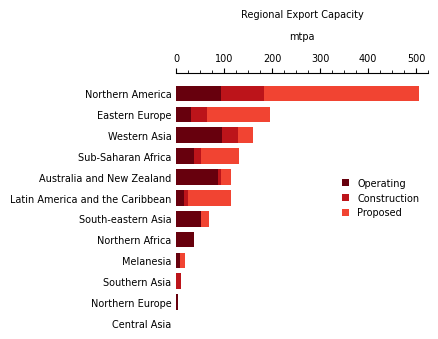

In [622]:
font_size = 7
xtop = 525
set_width=.75

mtpa_df_stripped = mtpa_by_region_export_df.droplevel(0).drop('')
mtpa_df_stripped = mtpa_df_stripped.loc[(mtpa_df_stripped!=0).any(axis=1)]
region_order = mtpa_df_stripped[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[::-1]
use_this_df = mtpa_df_stripped.loc[region_order,:]

fig = mp.figure(figsize=(3.25,3.25))

ax = fig.add_subplot(111)

ax.barh(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', height=set_width)
ax.barh(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      left=use_this_df['Operating'], height=set_width)
ax.barh(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df[['Operating','Construction']].sum(axis=1), height=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.set_xlim(0, xtop)
ax.set_ylim(0,region_order.__len__())

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(labelsize=font_size, left=False)
ax.tick_params(axis='y', which='major', pad=0)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
ax.set_xlabel('mtpa', size=font_size, labelpad=10)
ax.xaxis.tick_top()   
ax.xaxis.set_label_position('top') 

ax.set_title('Regional Export Capacity', fontsize=font_size, pad=10)

mp.savefig('saved-figures/regional-export-capacity-horizontal.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/regional-export-capacity-horizontal.pdf',
          bbox_inches='tight', 
          transparent=True)

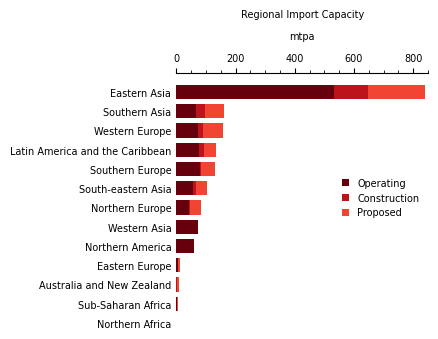

In [623]:
font_size = 7
xtop = 850
set_width=0.75

mtpa_df_stripped = mtpa_by_region_import_df.droplevel(0).drop('')
mtpa_df_stripped = mtpa_df_stripped.loc[(mtpa_df_stripped!=0).any(axis=1)]
region_order = mtpa_df_stripped[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[::-1]
use_this_df = mtpa_df_stripped.loc[region_order,:]

fig = mp.figure(figsize=(3.25,3.25))

ax = fig.add_subplot(111)

ax.barh(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', height=set_width)
ax.barh(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      left=use_this_df['Operating'], height=set_width)
ax.barh(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df[['Operating','Construction']].sum(axis=1), height=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.set_xlim(0, xtop)
ax.set_ylim(0,region_order.__len__())

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(labelsize=font_size, left=False)
ax.tick_params(axis='y', which='major', pad=0)

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
ax.set_xlabel('mtpa', size=font_size, labelpad=10)
ax.xaxis.tick_top()   
ax.xaxis.set_label_position('top') 

ax.set_title('Regional Import Capacity', fontsize=font_size, pad=10)

mp.savefig('saved-figures/regional-import-capacity-horizontal.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/regional-import-capacity-horizontal.pdf',
          bbox_inches='tight', 
          transparent=True)

## export and import capacity over time

## import

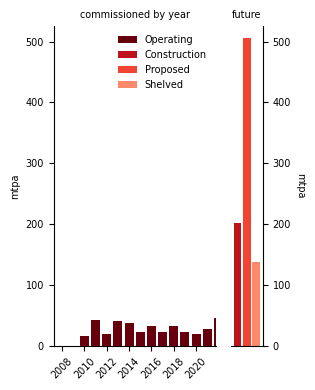

In [624]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['FacilityType']=='Import')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['FacilityType']=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 525
ytop2 = 525

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

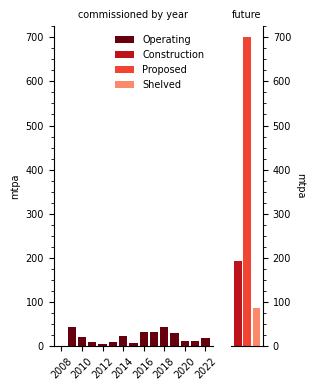

In [625]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['FacilityType']=='Export')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                     (terms_df_orig['FacilityType']=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 725
ytop2 = 725

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
ax2.minorticks_on()
ax2.tick_params(axis='x', which='minor',bottom=False)
ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

# redo fig above with big bars for each, not year-by-year

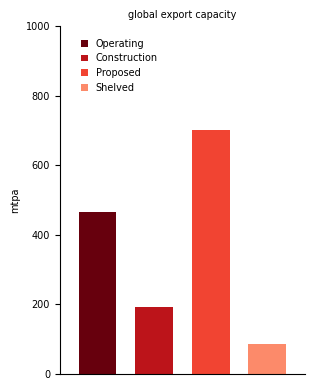

In [626]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['FacilityType']=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-summed-bars.pdf', bbox_inches='tight', transparent=True)

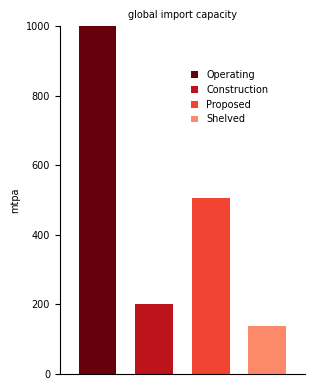

In [627]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['FacilityType']=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.5,0.9))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global import capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-import-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-import-summed-bars.pdf', bbox_inches='tight', transparent=True)

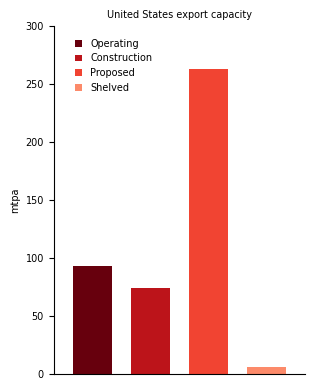

In [628]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                          (terms_df_orig['FacilityType']=='Export')&
                                          (terms_df_orig.Country=='United States')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 300
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('United States export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.pdf', bbox_inches='tight', transparent=True)

# Figure 4 - (new) plot of FacilityType for 2022, 2023, future

In [629]:
#shelved_2021_2022
shelved_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Export')&
                                   (terms_df_orig.Status=='Shelved')&
                                   (terms_df_orig.ShelvedYear.isin([2022,2023]))]['CapacityInMtpa'].sum(min_count=0)

shelved_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Import')&
                                   (terms_df_orig.Status=='Shelved')&
                                   (terms_df_orig.ShelvedYear.isin([2022,2023]))]['CapacityInMtpa'].sum(min_count=0)

#cancelled_2021_2022

cancelled_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Export')&
                                   (terms_df_orig.Status=='Cancelled')&
                                   (terms_df_orig.CancelledYear.isin([2022,2023]))]['CapacityInMtpa'].sum(min_count=0)

cancelled_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Import')&
                                   (terms_df_orig.Status=='Cancelled')&
                                   (terms_df_orig.CancelledYear.isin([2022,2023]))]['CapacityInMtpa'].sum(min_count=0)

#construction (present)
construction_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Export')&
                                   (terms_df_orig.Status=='Construction')]['CapacityInMtpa'].sum(min_count=0)

construction_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Import')&
                                   (terms_df_orig.Status=='Construction')]['CapacityInMtpa'].sum(min_count=0)

#proposed (present)
proposed_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Export')&
                                   (terms_df_orig.Status=='Proposed')]['CapacityInMtpa'].sum(min_count=0)

proposed_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['FacilityType']=='Import')&
                                   (terms_df_orig.Status=='Proposed')]['CapacityInMtpa'].sum(min_count=0)

In [630]:
pandas.DataFrame(index=['Export','Import'],
                data={'Shelved':[shelved_export,shelved_import],
                      'Cancelled':[cancelled_export,cancelled_import],
                      'Construction (October 2023)':[construction_export,construction_import],
                      'Proposed (October 2023)':[proposed_export,proposed_import]})

,Shelved,Cancelled,Construction (October 2023),Proposed (October 2023)
Export,56.20,83.18,192.65,701.54
Import,42.12,44.12,202.51,506.00


In [631]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [632]:
adjust_lightness('#fee948', amount=1)

(0.9960784313725491, 0.9137254901960785, 0.28235294117647036)

# cost calculations

## create offshore and floating dfs

## define quantiles

make empty est cost column to fill in costs

In [633]:
terms_df_floating = terms_df_orig.loc[(terms_df_orig.Floating=='yes')&
                                      ~(terms_df_orig.CostUSDPerMtpa.isnull())]
terms_df_onshore = terms_df_orig.loc[(terms_df_orig.Floating=='')&
                                    ~(terms_df_orig.CostUSDPerMtpa.isnull())]

orig_num_floating = terms_df_floating.shape[0]
orig_num_onshore = terms_df_onshore.shape[0]

# terminal costs are calculated separately for offshore and onshore
# export terminals are about 2x as expensive as import terminals to build
# try removing top/bottom 2.5%?
qlo_val = 0.1
qhi_val = 0.9

qlo_floating = terms_df_floating['CostUSDPerMtpa'].quantile(qlo_val)
qhi_floating = terms_df_floating['CostUSDPerMtpa'].quantile(qhi_val)
qlo_onshore = terms_df_onshore['CostUSDPerMtpa'].quantile(qlo_val)
qhi_onshore = terms_df_onshore['CostUSDPerMtpa'].quantile(qhi_val)
# REMOVE EVERYTHING OUTSIDE OF THOSE QUANTILES
terms_df_floating = terms_df_floating.loc[terms_df_floating['CostUSDPerMtpa'].between(qlo_floating,qhi_floating,inclusive='both')]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore['CostUSDPerMtpa'].between(qlo_onshore,qhi_onshore,inclusive='both')]

# REMOVING ANYTHING OVER 1 billion per mtpa
# terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
# terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

new_num_floating = terms_df_floating.shape[0]
new_num_onshore = terms_df_onshore.shape[0]

In [634]:
new_num_floating/orig_num_floating

0.8061224489795918

In [635]:
new_num_onshore/orig_num_onshore

0.7992831541218638

array([[<Axes: title={'center': 'CostUSDPerMtpa'}>]], dtype=object)

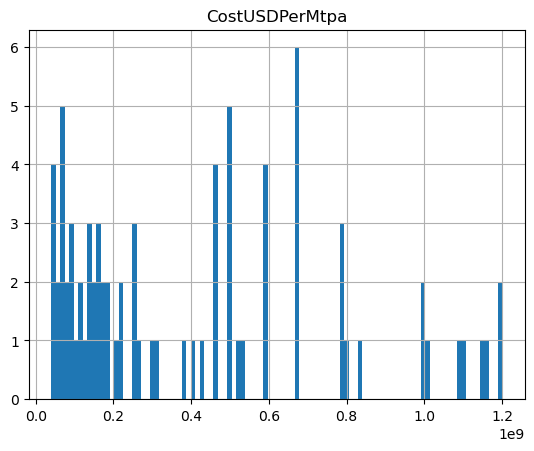

In [636]:
terms_df_floating.hist('CostUSDPerMtpa', bins=100)

array([[<Axes: title={'center': 'CostUSDPerMtpa'}>]], dtype=object)

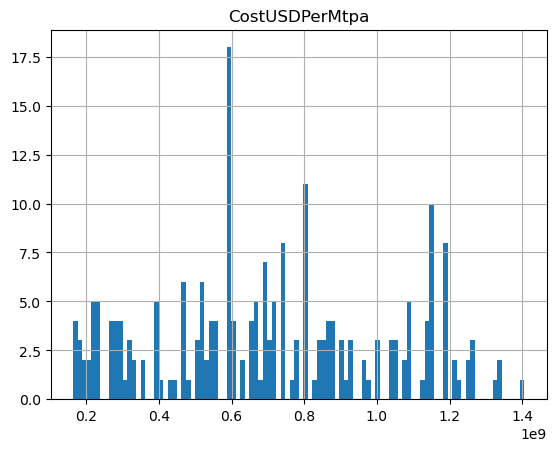

In [637]:
terms_df_onshore.hist('CostUSDPerMtpa', bins=100)

create a "noexpansions" dataframe that removes all expansion projects (assuming these will throw off cost calculations) and only keep one cost data point from each unique TerminalName

In [638]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion', na=False)].drop_duplicates(subset=['TerminalID'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion', na=False)].drop_duplicates(subset=['TerminalID'], keep='first')

## import

In [639]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Klaipeda FSRU,Lithuania,Operating,https://www.gem.wiki/Klaipeda_FSRU,39586206.900000
Skulte LNG Terminal,Latvia,Proposed,https://www.gem.wiki/Skulte_FRU,39966666.670000
NextDecade Cork FSRU,Ireland,Cancelled,https://www.gem.wiki/NextDecade_Cork_FSRU,46324995.680000
Moheshkhali FLNG Terminal (Petrobangla),Bangladesh,Operating,https://www.gem.wiki/Moheshkhali_FLNG_Terminal_(Petrobangla),47236842.110000
H-Energy Kakinada LNG Terminal,India,Proposed,https://www.gem.wiki/H-Energy_Kakinada_LNG_Terminal,52000000.000000
Philippines LNG Terminal,Philippines,Operating,https://www.gem.wiki/Philippines_LNG_Terminal,52560000.000000
Mumbai FSRU,India,Shelved,https://www.gem.wiki/Mumbai_FSRU,69940000.000000
LNG Alliance Mangalore FSRU,India,Proposed,https://www.gem.wiki/LNG_Alliance_Mangalore_FSRU,72500000.000000
Geelong FSRU Terminal,Australia,Proposed,https://www.gem.wiki/Geelong_FSRU,72637200.000000
Argo FSRU,Greece,Proposed,https://www.gem.wiki/Argo_FSRU_Terminal,72992080.140000


In [640]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Mariveles LNG Terminal,Philippines,Proposed,https://www.gem.wiki/Mariveles_LNG_Terminal,167500000.000000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.710000
Cacouna LNG Terminal,Canada,Cancelled,https://www.gem.wiki/Cacouna_LNG_Terminal,173684210.530000
Porto Empedocle LNG Terminal,Italy,Proposed,https://www.gem.wiki/Porto_Empedocle_LNG_Terminal,185299982.710000
Brunsbüttel LNG Terminal,Germany,Construction,https://www.gem.wiki/Brunsb%C3%BCttel_LNG_Terminal,185299982.710000
Zhejiang Energy Liuheng LNG Terminal,China,Proposed,https://www.gem.wiki/Zhejiang_Energy_Liuheng_LNG_Terminal,188976377.950000
Haldia LNG Terminal,India,Cancelled,https://www.gem.wiki/Haldia_LNG_Terminal,195000000.000000
Chaozhou LNG Terminal (Huaying）,China,Construction,https://www.gem.wiki/Chaozhou_LNG_Terminal_(Huaying),197306666.670000
HIGAS LNG Terminal,Italy,Operating,https://www.gem.wiki/HIGAS_LNG_Terminal,208190000.000000
Rizhao LNG Terminal,China,Shelved,https://www.gem.wiki/Rizhao_LNG_Terminal,214400000.000000


## export list

In [641]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Atlantic LNG Terminal,Trinidad and Tobago,Mothballed,https://www.gem.wiki/Atlantic_LNG_Terminal,217821781.820000
Qatargas 1 Ras Laffan LNG Terminal,Qatar,Operating,https://www.gem.wiki/Qatargas_1_Ras_Laffan_LNG_Terminal,232323232.120000
Egyptian LNG Terminal,Egypt,Operating,https://www.gem.wiki/ELNG_IDCO_Terminal,268055555.560000
Oman Qalhat LNG Terminal,Oman,Operating,https://www.gem.wiki/Oman_Qalhat_LNG_Terminal,281690140.850000
Gibbstown Deepwater Port LNG Terminal,United States,Proposed,https://www.gem.wiki/Gibbstown_Deepwater_Port_LNG_Terminal,300000000.000000
Tangguh LNG Terminal,Indonesia,Operating,https://www.gem.wiki/Tangguh_LNG_Terminal,315789473.680000
New Fortress Wyalusing LNG Terminal,United States,Proposed,https://www.gem.wiki/New_Fortress_Wyalusing_LNG_Terminal,388884540.120000
Punta Europa LNG Terminal,Equatorial Guinea,Operating,https://www.gem.wiki/Punta_Europa_LNG_Terminal,405405405.410000
Darwin LNG Terminal,Australia,Operating,https://www.gem.wiki/Darwin_LNG_Terminal,432432432.430000
Fourchon LNG Terminal,United States,Proposed,https://www.gem.wiki/Fourchon_LNG_Terminal,444000000.000000


In [642]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Marshal Vasilevskiy FSRU,Russia,Idle,https://www.gem.wiki/Marshal_Vasilevskiy_FSRU,156493136.080000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.140000
Djibouti FLNG Terminal,Djibouti,Shelved,https://www.gem.wiki/Djibouti_FLNG_Terminal,300000000.000000
New Fortress Altamira FLNG Terminal,Mexico,Construction,https://www.gem.wiki/New_Fortress_Altamira_FLNG_Terminal,309523809.290000
Etinde FLNG Terminal,Cameroon,Proposed,https://www.gem.wiki/Etinde_FLNG_Terminal,384615384.620000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000
Cameroon FLNG Terminal,Cameroon,Operating,https://www.gem.wiki/Cameroon_FLNG_Terminal,500000000.000000
New Fortress Grand Isle FLNG Terminal,United States,Proposed,https://www.gem.wiki/New_Fortress_Grand_Isle_FLNG_Terminal,500000000.000000
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,592592592.590000
Main Pass Energy Hub FLNG Terminal,United States,Cancelled,https://www.gem.wiki/Main_Pass_Energy_Hub_FLNG_Terminal,666666666.670000


### make dataframe to use for terminal calculations

* use regional averages for onshore terminals
* Subregions will inherit larger Region values
  * if Region has fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [643]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values[0]

onshore_export_regional_costs = onshore_export_regional_costs.loc[~(onshore_export_regional_costs.index=='--')]

print('export onshore')
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,6,6.791534e+08
Americas,34,7.486237e+08
Asia,7,6.346310e+08
Europe,8,1.150071e+09
Oceania,6,7.700058e+08


### which are going into this? question for Rob and Alison Kirsch

In [644]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')&
                                   (terms_df_onshore_noexpansions.Region=='North America')].to_excel('terminals_df_onshore_export.xlsx', index=False)

In [645]:
a = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')&
                                    (terms_df_onshore_noexpansions.Region=='North America')].TerminalID.unique()
for i in a:
    #print(terms_df_onshore_noexpansions.loc[terms_df_onshore_noexpansions.TerminalID==i]['TerminalName'])
    print(terms_df_onshore_noexpansions.loc[terms_df_onshore_noexpansions.TerminalID==i]['CostUSDPerMtpa'].values[0]/1e6)

In [646]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values[0]

onshore_import_regional_costs = onshore_import_regional_costs.loc[~(onshore_import_regional_costs.index=='--')]
print('import onshore')
onshore_import_regional_costs.replace(numpy.nan,0)

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,2.0,3.862991e+08
Americas,4.0,3.017544e+08
Asia,22.0,3.650116e+08
Europe,7.0,4.447106e+08
Oceania,0.0,3.862991e+08


In [647]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values[0]

floating_export_regional_costs = floating_export_regional_costs.loc[~(floating_export_regional_costs.index=='--')]

print('export floating')
floating_export_regional_costs.replace(numpy.nan,0)

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,5.0,6.693999e+08
Americas,7.0,6.693999e+08
Asia,4.0,6.693999e+08
Europe,2.0,6.693999e+08
Oceania,0.0,6.693999e+08


In [648]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
    terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                       (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values[0]

floating_import_regional_costs = floating_import_regional_costs.loc[~(floating_import_regional_costs.index=='--')]

print('import floating')
floating_import_regional_costs.replace(numpy.nan,0)

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Africa,2.0,1.646520e+08
Americas,0.0,1.646520e+08
Asia,13.0,1.646520e+08
Europe,19.0,1.646520e+08
Oceania,4.0,1.646520e+08


### global calculations

In [649]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_mdn = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].median().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_mdn = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].median().values
cost_floating_export_std = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_mdn = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].median().values
cost_onshore_import_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_mdn = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].median().values
cost_floating_import_std = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['FacilityType']=='Import')][['CostUSDPerMtpa']].std().values

In [650]:
cost_onshore_export

array([7.83461375e+08])

In [651]:
cost_onshore_export_mdn

array([7.61904762e+08])

In [652]:
cost_onshore_export_std

array([3.17962006e+08])

In [653]:
cost_floating_export

array([6.69399921e+08])

In [654]:
cost_floating_export_mdn

array([6.2962963e+08])

In [655]:
cost_floating_export_std

array([3.3584401e+08])

In [656]:
cost_onshore_import

array([3.86299056e+08])

In [657]:
cost_onshore_import_mdn

array([2.95935e+08])

In [658]:
cost_onshore_import_std

array([2.50738021e+08])

In [659]:
cost_floating_import

array([1.64652017e+08])

In [660]:
cost_floating_import_mdn

array([1.24438468e+08])

In [661]:
cost_floating_import_std

array([1.84803978e+08])

### calculate how much export/import capacity data we have

In [662]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)

In [663]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(558/663 * 100)

(663, 82)
(558, 82)
84.16289592760181


In [664]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['FacilityType']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(558/595 * 100)

(595, 82)
(568, 82)
93.78151260504201


## now calculate the import terminal costs

In [665]:
terms_df_import = terms_df_orig.loc[terms_df_orig['FacilityType']=='Import'].reset_index(drop=True)

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostUSD']

## and calculate export terminal costs

In [666]:
terms_df_export = terms_df_orig.loc[terms_df_orig['FacilityType']=='Export'].reset_index(drop=True)

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostUSD']

## import terminal costs table

In [667]:
#mtpa by country

cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby(['Region','SubRegion','Country'])['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby(['Region','SubRegion'])['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_region_import_df.index.names = ['Region','Subregion']
cost_by_country_import_df.index.names = ['Region','Subregion','Country']

# total
cost_by_region_import_df.loc[('Total',''),:] = cost_by_region_import_df.sum(axis=0)
cost_by_country_import_df.loc[('Total','',''),:] = cost_by_country_import_df.sum(axis=0)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df_full = cost_by_region_import_df.copy()
cost_by_region_import_df = cost_by_region_import_df.loc[~(cost_by_region_import_df==0).all(axis=1)]
cost_by_region_import_df = cost_by_region_import_df.sort_values('Region')

(cost_by_region_import_df/1e9).to_excel('cost-by-region-import-billionUSD.xlsx')
cost_by_region_import_df/1e9

Proposed  Construction  \
Region   Subregion                                                   
Africa   Sub-Saharan Africa                 1.014652      0.350000   
         Northern Africa                    0.000000      0.000000   
Americas Latin America and the Caribbean    6.112959      2.644311   
         Northern America                   0.015088      0.000000   
Asia     Eastern Asia                      67.561583     38.931554   
         Southern Asia                     12.557966      7.480334   
         South-eastern Asia                12.174912      2.377733   
         Western Asia                       0.000000      0.367330   
Europe   Western Europe                    16.081084      3.006403   
         Southern Europe                    9.609323      0.392400   
         Northern Europe                    5.953085      0.763000   
         Eastern Europe                     1.220798      0.684854   
Oceania  Australia and New Zealand          1.100732      0.181593   
Total                                     133.402182     57.179513   

                                          Proposed+Construction    Shelved  \
Region   Subregion                                                           
Africa   Sub-Saharan Africa                            1.364652   0.144894   
         Northern Africa                               0.000000   4.894035   
Americas Latin America and the Caribbean               8.757270   2.092997   
         Northern America                              0.015088   0.000000   
Asia     Eastern Asia                                106.493137  12.368600   
         Southern Asia                                20.038300   5.970300   
         South-eastern Asia                           14.552645   9.520181   
         Western Asia                                  0.367330   1.827637   
Europe   Western Europe                               19.087487   0.000000   
         Southern Europe                              10.001723   0.436000   
         Northern Europe                               6.716085   0.000000   
         Eastern Europe                                1.905652   2.668263   
Oceania  Australia and New Zealand                     1.282325   0.427833   
Total                                                190.581695  40.350741   

                                           Cancelled   Operating       Idle  \
Region   Subregion                                                            
Africa   Sub-Saharan Africa                 1.267821    0.411630   0.000000   
         Northern Africa                    4.110222    0.000000   0.938516   
Americas Latin America and the Caribbean    7.054949   16.360292   0.000000   
         Northern America                  70.352552   16.386942   7.132553   
Asia     Eastern Asia                      18.441576  190.261568   0.000000   
         Southern Asia                     17.768198   19.855609   0.000000   
         South-eastern Asia                12.754658   11.283126   0.000000   
         Western Asia                       2.920093   14.690291   3.773619   
Europe   Western Europe                     5.514411   22.864988   0.000000   
         Southern Europe                   18.573934   33.004894   0.000000   
         Northern Europe                    7.671666   17.116557   0.000000   
         Eastern Europe                     1.210000    2.110859   0.000000   
Oceania  Australia and New Zealand          0.181593    0.000000   0.000000   
Total                                     167.821672  344.346755  11.844688   

                                          Mothballed   Retired  
Region   Subregion                                              
Africa   Sub-Saharan Africa                 0.000000  0.000000  
         Northern Africa                    0.691538  0.000000  
Americas Latin America and the Caribbean    0.000000  0.000000  
         Northern America                  13.578947  5.220351  
Asia     Eastern As

## export terminal costs table

In [668]:
#mtpa by country

cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

for status in status_list:
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby(['Region','SubRegion','Country'])['CostUSDTotal'].sum()

for status in status_list:
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby(['Region','SubRegion'])['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_region_export_df.index.names = ['Region','Subregion']

# total
cost_by_region_export_df.loc[('Total',''),:] = cost_by_region_export_df.sum(axis=0)
cost_by_country_export_df.loc[('Total','',''),:] = cost_by_country_export_df.sum(axis=0)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df_full = cost_by_region_export_df.copy()
cost_by_region_export_df = cost_by_region_export_df.loc[~(cost_by_region_export_df==0).all(axis=1)]
cost_by_region_export_df = cost_by_region_export_df.sort_values('Region')

(cost_by_region_export_df/1e9).to_excel('cost-by-region-export-billionUSD.xlsx')
cost_by_region_export_df/1e9

Proposed  Construction  \
Region   Subregion                                                   
Africa   Sub-Saharan Africa               107.379731     10.009505   
         Northern Africa                    0.000000      0.047541   
Americas Northern America                 245.639027     80.479154   
         Latin America and the Caribbean   79.306509      3.733027   
Asia     Western Asia                      23.643958     28.750000   
         South-eastern Asia                25.431342      0.000000   
         Southern Asia                      0.000000     10.000000   
         Central Asia                       0.000000      0.000000   
Europe   Eastern Europe                   152.400962     39.093044   
         Northern Europe                    0.000000      0.000000   
Oceania  Australia and New Zealand         28.431060      5.600000   
         Melanesia                         18.270689      0.000000   
Total                                     680.503279    177.712271   

                                          Proposed+Construction    Shelved  \
Region   Subregion                                                           
Africa   Sub-Saharan Africa                          117.389236  24.000000   
         Northern Africa                               0.047541   0.000000   
Americas Northern America                            326.118181   4.000000   
         Latin America and the Caribbean              83.039536   0.000000   
Asia     Western Asia                                 52.393958  13.961882   
         South-eastern Asia                           25.431342   0.000000   
         Southern Asia                                10.000000   0.000000   
         Central Asia                                  0.000000   0.000000   
Europe   Eastern Europe                              191.494006  15.700706   
         Northern Europe                               0.000000   0.000000   
Oceania  Australia and New Zealand                    34.031060  17.250000   
         Melanesia                                    18.270689   1.155009   
Total                                                858.215550  76.067597   

                                           Cancelled   Operating      Idle  \
Region   Subregion                                                           
Africa   Sub-Saharan Africa                18.818413   35.227206  0.000000   
         Northern Africa                    3.395767   22.690515  0.000000   
Americas Northern America                 342.764950   72.682349  0.000000   
         Latin America and the Caribbean   14.922261    6.481188  0.000000   
Asia     Western Asia                      21.362458   54.689702  0.000000   
         South-eastern Asia                 1.872161   34.039680  6.092458   
         Southern Asia                     40.713242    0.000000  0.000000   
         Central Asia                       0.000000    0.126926  0.000000   
Europe   Eastern Europe                    18.689173   47.429229  0.588000   
         Northern Europe                    0.000000    6.440533  0.000000   
Oceania  Australia and New Zealand         34.571485  180.642026  0.000000   
         Melanesia                          8.250000   19.000000  0.000000   
Total                                     505.359909  479.449355  6.680458   

                                          Mothballed    Retired  
Region   Subregion                                               
Africa   Sub-Saharan Africa                 0.000000   0.000000  
         Northern Africa                    2.173291   5.297397  
Americas Northern America                   1.122936   0.000000  
         Latin America and the Caribbean    1.020042   0.000000  
Asia     Western Asia                       4.569343   0.000000  
         South-eastern Asia                 0.000000  19.102393  
         Southern Asia                      0.000000   0.000000  
         Central Asia                       0.000000   0.

## add import + export costs together

In [669]:
cost_by_region_TOTAL = cost_by_region_import_df_full + cost_by_region_export_df_full
cost_by_region_TOTAL = cost_by_region_TOTAL.loc[~(cost_by_region_TOTAL==0).all(axis=1)]
(cost_by_region_TOTAL/1e9).to_excel('cost-by-region-TOTAL-billionUSD.xlsx')
cost_by_region_TOTAL/1e9

Proposed  Construction  \
Region   Subregion                                                   
Africa   Northern Africa                    0.000000      0.047541   
         Sub-Saharan Africa               108.394383     10.359505   
Americas Latin America and the Caribbean   85.419468      6.377338   
         Northern America                 245.654115     80.479154   
Asia     Central Asia                       0.000000      0.000000   
         Eastern Asia                      67.561583     38.931554   
         South-eastern Asia                37.606254      2.377733   
         Southern Asia                     12.557966     17.480334   
         Western Asia                      23.643958     29.117330   
Europe   Eastern Europe                   153.621760     39.777898   
         Northern Europe                    5.953085      0.763000   
         Southern Europe                    9.609323      0.392400   
         Western Europe                    16.081084      3.006403   
Oceania  Australia and New Zealand         29.531792      5.781593   
         Melanesia                         18.270689      0.000000   
Total                                     813.905460    234.891784   

                                          Proposed+Construction     Shelved  \
Region   Subregion                                                            
Africa   Northern Africa                               0.047541    4.894035   
         Sub-Saharan Africa                          118.753888   24.144894   
Americas Latin America and the Caribbean              91.796806    2.092997   
         Northern America                            326.133269    4.000000   
Asia     Central Asia                                  0.000000    0.000000   
         Eastern Asia                                106.493137   12.368600   
         South-eastern Asia                           39.983987    9.520181   
         Southern Asia                                30.038300    5.970300   
         Western Asia                                 52.761288   15.789520   
Europe   Eastern Europe                              193.399659   18.368970   
         Northern Europe                               6.716085    0.000000   
         Southern Europe                              10.001723    0.436000   
         Western Europe                               19.087487    0.000000   
Oceania  Australia and New Zealand                    35.313385   17.677833   
         Melanesia                                    18.270689    1.155009   
Total                                               1048.797245  116.418339   

                                           Cancelled   Operating       Idle  \
Region   Subregion                                                            
Africa   Northern Africa                    7.505989   22.690515   0.938516   
         Sub-Saharan Africa                20.086233   35.638836   0.000000   
Americas Latin America and the Caribbean   21.977210   22.841480   0.000000   
         Northern America                 413.117502   89.069290   7.132553   
Asia     Central Asia                       0.000000    0.126926   0.000000   
         Eastern Asia                      18.441576  190.261568   0.000000   
         South-eastern Asia                14.626820   45.322806   6.092458   
         Southern Asia                     58.481440   19.855609   0.000000   
         Western Asia                      24.282550   69.379994   3.773619   
Europe   Eastern Europe                    19.899173   49.540088   0.588000   
         Northern Europe                    7.671666   23.557090   0.000000   
         Southern Europe                   18.573934   33.004894   0.000000   
         Western Europe                     5.514411   22.864988   0.000000   
Oceania  Australia and New Zealand         34.753078  180.642026   0.000000   
         Melanesia                          8.250000   19.000000   0.000000   
Total            

### PLOT - treemap (squarify)

In [953]:
cost_by_region_TOTAL_sum = pandas.DataFrame(cost_by_region_TOTAL.drop('Total').groupby(
    ['Region','Colors'])['Proposed+Construction'].sum()).sort_values(
    'Proposed+Construction', ascending=False).reset_index(level=1)

In [954]:
cost_by_subregion_TOTAL_sum = pandas.DataFrame(cost_by_region_TOTAL.drop('Total').groupby(
    ['Region','Subregion'])['Proposed+Construction'].sum()).reset_index(level=1)

In [955]:
# list is ordered from largest to smallest...
# it must be ordered properly
treemap_colors = {'Americas':'#580000',
                  'Asia':'#902c00',
                  'Europe':'#c75a00',
                  'Africa':'#f98c28',
                  'Oceania':'#ffd370'}

cost_by_region_TOTAL['Colors'] = str(numpy.nan)
for idx,row in cost_by_region_TOTAL.iterrows():
    if idx!=('Total',''):
        cost_by_region_TOTAL.loc[idx,'Colors'] = treemap_colors[idx[0]]

In [956]:
cost_by_region_TOTAL_sum

,Colors,Proposed+Construction
Region,,
Americas,#580000,4.179301e+11
Asia,#902c00,2.292767e+11
Europe,#c75a00,2.292050e+11
Africa,#f98c28,1.188014e+11
Oceania,#ffd370,5.358407e+10


In [959]:
#normalize sizes
normalized_region_values = squarify.normalize_sizes(cost_by_region_TOTAL_sum['Proposed+Construction'].values,dx=100,dy=100)
squarify.normalize_sizes(cost_by_region_TOTAL_sum['Proposed+Construction'].values,dx=100,dy=100)

[3984.8510028075184,
 2186.0918613166377,
 2185.4076665106372,
 1132.739715349963,
 510.909754015244]

In [960]:
squarified_region_values = squarify.squarify(normalized_region_values,0,0,100,100)
squarify.squarify(normalized_region_values,0,0,100,100)

[{'x': 0, 'y': 0, 'dx': 61.70942864124156, 'dy': 64.57442712643054},
 {'x': 0,
  'y': 64.57442712643054,
  'dx': 61.70942864124156,
  'dy': 35.425572873569465},
 {'x': 61.70942864124156,
  'y': 0,
  'dx': 38.29057135875844,
  'dy': 57.07430286257025},
 {'x': 61.70942864124156,
  'y': 57.07430286257025,
  'dx': 38.29057135875844,
  'dy': 29.58273212318793},
 {'x': 61.70942864124156,
  'y': 86.65703498575817,
  'dx': 38.29057135875846,
  'dy': 13.34296501424182}]

In [961]:
squarified_region_values

[{'x': 0, 'y': 0, 'dx': 61.70942864124156, 'dy': 64.57442712643054},
 {'x': 0,
  'y': 64.57442712643054,
  'dx': 61.70942864124156,
  'dy': 35.425572873569465},
 {'x': 61.70942864124156,
  'y': 0,
  'dx': 38.29057135875844,
  'dy': 57.07430286257025},
 {'x': 61.70942864124156,
  'y': 57.07430286257025,
  'dx': 38.29057135875844,
  'dy': 29.58273212318793},
 {'x': 61.70942864124156,
  'y': 86.65703498575817,
  'dx': 38.29057135875846,
  'dy': 13.34296501424182}]

In [962]:
len(squarified_region_values)

5

In [966]:
cost_by_subregion_TOTAL_sum

,Subregion,Proposed+Construction
Region,,
Africa,Northern Africa,4.754074e+07
Africa,Sub-Saharan Africa,1.187539e+11
Americas,Latin America and the Caribbean,9.179681e+10
Americas,Northern America,3.261333e+11
Asia,Central Asia,0.000000e+00
Asia,Eastern Asia,1.064931e+11
Asia,South-eastern Asia,3.998399e+10
Asia,Southern Asia,3.003830e+10
Asia,Western Asia,5.276129e+10


Americas
Asia
Europe
Africa
Oceania


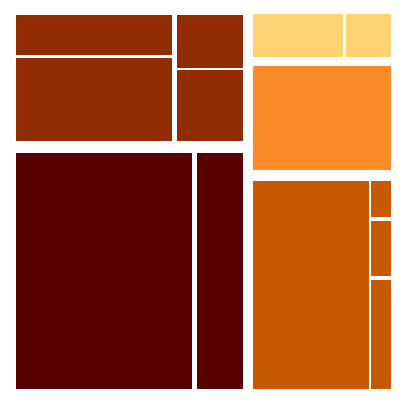

In [963]:
fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111, frameon=False)
ax.axis('off')

ax_bbox = ax.get_position() # gives x0, y0, xwidth, yheight
x_scale = ax_bbox.bounds[2]
y_scale = ax_bbox.bounds[3]

# region_values = squarify.plot(normalized_region_values,
#                               norm_x=100,
#                               norm_y=100,
#                               ax=ax,
#                               pad=True)

squarified_region_values = squarify.padded_squarify(normalized_region_values,0,0,100,100) # in axes space?

for i in range(len(squarified_region_values)):

    region_name = cost_by_region_TOTAL_sum.index.tolist()[i]
    print(region_name)
    
    subregion_values_df = cost_by_subregion_TOTAL_sum.loc[region_name]
    # drop anything equal to zero
    subregion_values_df = subregion_values_df.loc[subregion_values_df['Proposed+Construction']!=0]
    subregion_values = subregion_values_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].values
    
    normalized_subregion_values = squarify.normalize_sizes(subregion_values,
                                                           dx=squarified_region_values[i]['dx'],
                                                           dy=squarified_region_values[i]['dy'])

    ax_new = fig.add_axes([squarified_region_values[i]['x']/100*y_scale+ax_bbox.bounds[0],
                           squarified_region_values[i]['y']/100*y_scale+ax_bbox.bounds[1],
                           squarified_region_values[i]['dx']/100*x_scale,
                           squarified_region_values[i]['dy']/100*y_scale],
                         frameon=True,
                         transform=ax.transAxes)

    ax_new.axis('off')
    
    # subregion squarify plot

    squarify.plot(normalized_subregion_values,
                  norm_x=100,
                  norm_y=100,
                  ax=ax_new,
                  pad=True,
                  color=[treemap_colors[region_name]]*normalized_subregion_values.__len__())

#ax.axvline(x=61.70942864124156

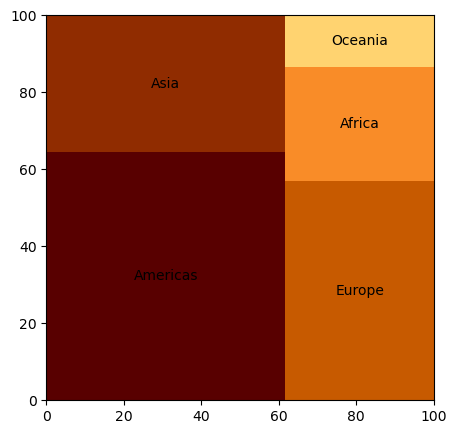

In [750]:
label_list = []
cost_by_region_TOTAL_sum.index.tolist()
#for 

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

squarify.plot(cost_by_region_TOTAL_sum['Proposed+Construction'].values/1e9,
              color=cost_by_region_TOTAL_sum['Colors'].values,
              label=cost_by_region_TOTAL_sum.index.tolist())

treemap_fig = mp.gcf()

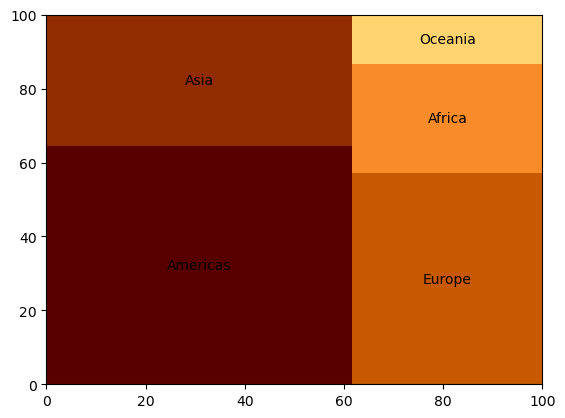

In [703]:
treemap_fig.get

In [698]:
fig.get_axes()

[]

# pie charts with costs, mtpa

## import

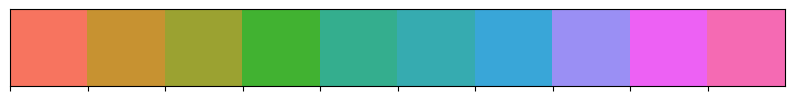

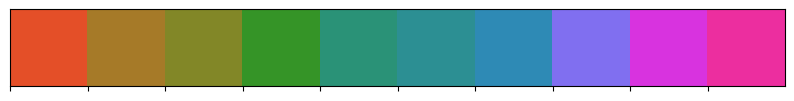

In [423]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, h=0.05, s=0.9, l=0.65))
seaborn.palplot(seaborn.husl_palette(10, h=0.05, l=0.55))

cmap_light = seaborn.husl_palette(10, h=0.05, l=0.6, s=0.9, as_cmap=True)
cmap_dark = seaborn.husl_palette(10, h=0.05, l=0.4, as_cmap=True)

## big panel figure

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/981234680.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(region_order, rotation=45, ha='right', va='top')
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/981234680.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(region_order, rotation=45, ha='right', va='top')


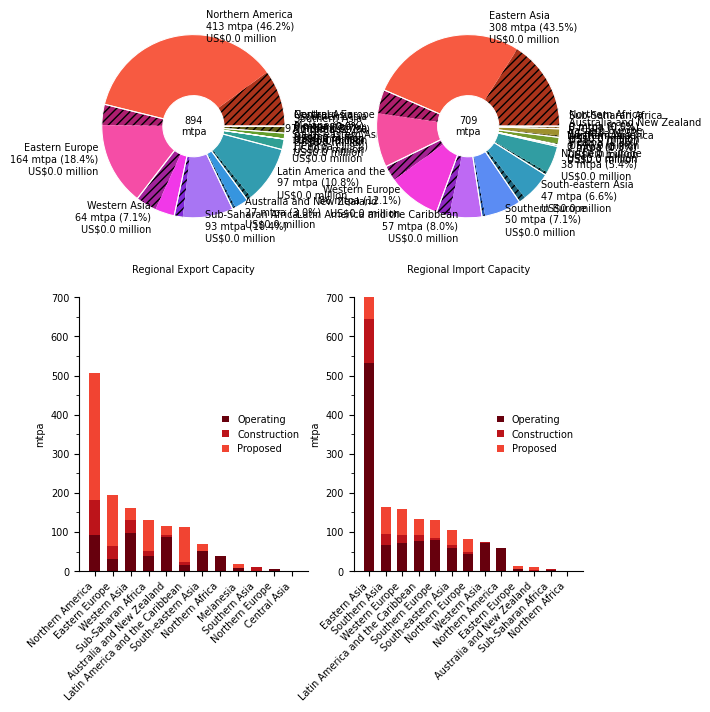

In [424]:
font_size=7
ytop = 700
set_width=0.6
pie_chart_line_width=0.75

fig = mp.figure(figsize=(6.5,8))#, constrained_layout=True)
widths = [1,1]
heights = [1.25,1]
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=2, figure=fig,
                                 wspace=0.2, hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

################################################################## TOP LEFT
ax1 = fig.add_subplot(gs[0,0])

mtpa_df_stripped = mtpa_by_region_export_df.droplevel(0).drop('')
mtpa_df_stripped = mtpa_df_stripped.loc[(mtpa_df_stripped!=0).any(axis=1)]
region_order = mtpa_df_stripped[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index
use_this_df = mtpa_df_stripped.loc[region_order,:]

pie_vals = use_this_df.loc[region_order]['Proposed+Construction'].values
pie_labels = use_this_df.index
nwedges = pie_labels.__len__()

pie_labels_mtpa = use_this_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (use_this_df.loc[region_order]['Proposed+Construction'] / 
                   use_this_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = use_this_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = use_this_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
pie1 = ax1.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax1.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=pie_chart_line_width, width=pie_width),
       textprops={'fontsize': font_size})

ax1_pie_total_mtpa = '{:.0f}'.format(mtpa_by_region_export_df.loc[('Total',''),'Proposed+Construction'])+'\nmtpa'

hatch_list = ['////','']*nwedges
for i in range(pie1[0].__len__()):
    pie1[0][i].set(hatch=hatch_list[i])

################################################################## LOWER LEFT
ax3 = fig.add_subplot(gs[1,0])

ax3.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax3.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax3.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax3_l,ax3_h = ax3.get_legend_handles_labels()
ax3.legend(ax3_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(labelsize=font_size)
ax3.set_xticklabels(region_order, rotation=45, ha='right', va='top')
ax3.set_ylabel('mtpa', size=font_size)

ax3.set_ylim(0, ytop)
ax3.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

################################################################## TOP RIGHT
ax2 = fig.add_subplot(gs[0,1])

mtpa_df_stripped = mtpa_by_region_import_df.droplevel(0).drop('')
mtpa_df_stripped = mtpa_df_stripped.loc[(mtpa_df_stripped!=0).any(axis=1)]
region_order = mtpa_df_stripped[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index
use_this_df = mtpa_df_stripped.loc[region_order,:]

pie_vals = use_this_df.loc[region_order]['Proposed+Construction'].values
pie_labels = use_this_df.index
nwedges = pie_labels.__len__()

pie_labels_mtpa = use_this_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (use_this_df.loc[region_order]['Proposed+Construction'] / 
                   use_this_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = use_this_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = use_this_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
pie2 = ax2.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax2.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=pie_chart_line_width, width=pie_width),
       textprops={'fontsize': font_size})

ax2_pie_total_mtpa = '{:.0f}'.format(mtpa_by_region_import_df.loc[('Total',''),'Proposed+Construction'])+'\nmtpa'

hatch_list = ['////','']*nwedges
for i in range(pie2[0].__len__()):
    pie2[0][i].set(hatch=hatch_list[i])

################################################################## LOWER RIGHT
ax4 = fig.add_subplot(gs[1,1])

ax4.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax4.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax4.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax4_l,ax4_h = ax4.get_legend_handles_labels()
ax4.legend(ax4_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.tick_params(labelsize=font_size)
ax4.set_xticklabels(region_order, rotation=45, ha='right', va='top')
#ax.set_xlabel('start year', size=font_size)
ax4.set_ylabel('mtpa', size=font_size)

ax4.set_ylim(0, ytop)
ax4.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax1.tick_params(labelsize=font_size)
ax2.tick_params(labelsize=font_size)
ax3.tick_params(labelsize=font_size)
ax4.tick_params(labelsize=font_size)

ax1.text(x=0,y=0,s=ax1_pie_total_mtpa,size=font_size,
        va='center',
        ha='center')
ax2.text(x=0,y=0,s=ax2_pie_total_mtpa,size=font_size,
        va='center',
        ha='center')

ax3.text(x=0.5, y=1.1, s='Regional Export Capacity',
         ha='center', va='center',
         size=font_size, transform=ax3.transAxes)
ax4.text(x=0.5, y=1.1, s='Regional Import Capacity', 
         ha='center', va='center',
         size=font_size, transform=ax4.transAxes)

#fig.tight_layout()
mp.savefig('saved-figures/panel-figure-import-export-capacity-updated.pdf', bbox_inches='tight')
mp.savefig('saved-figures/panel-figure-import-export-capacity-updated.png', bbox_inches='tight', transparent=True, dpi=600)

# cumulative sum 2023 onward

In [425]:
terms_df_export_const_fid = terms_df_orig.loc[(terms_df_orig.FacilityType=='Export')&
                                                ((terms_df_orig.Status.isin(['Operating','Construction'])) |
                                                          (terms_df_orig.FIDStatus=='FID'))]

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/2920323376.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


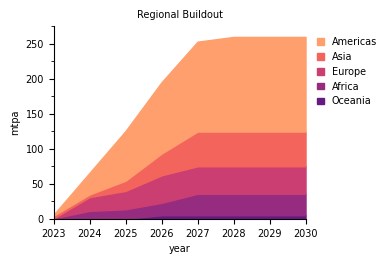

In [426]:
# fill up new capacities as they come online

start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_americas = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('Region')['CapacityInMtpa'].sum()
    
    terms_df_export_const_fid_subset_americas = terms_df_export_const_fid.loc[(terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export_const_fid.Region=='Americas')]
    mtpa_sum_americas[yr_idx:] += terms_df_export_const_fid_subset_americas['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

region_list = mtpa_sum_regional_cumsum.columns.values

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))
#fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

#new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.3,0.8,region_list.__len__())]

for region_idx in range(region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        color=region_colors[region_idx], 
                        label=region_list[region_idx])
    # else:
    #     if new_region_list[region_idx]=='North America':
    #         ax.fill_between(year_list, 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]], 
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     color=matplotlib.cm.get_cmap('magma')(0.2), 
    #                     label='Other North America')
    #         ax.fill_between(year_list,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam,
    #                     mtpa_sum_regional_cumsum_byregion[new_region_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
    #                     color=matplotlib.cm.get_cmap('magma')(0.3), 
    #                     label='United States')    
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[region_list[region_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[region_list[region_idx]], 
                    color=region_colors[region_idx], 
                    label=region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
#ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
#ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-regional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-regional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
mp.savefig('saved-figures/mtpa-regional-export-timeseries.svg', bbox_inches='tight', transparent=True)

In [427]:
mtpa_sum_regional_cumsum_byregion

,Oceania,Africa,Europe,Asia,Americas
2023,0.0,0.60,0.60,4.40,5.95
2024,0.0,11.19,30.89,34.69,65.73
2025,0.0,13.59,39.79,54.39,125.51
2026,5.0,22.69,61.99,93.09,195.09
2027,5.0,35.59,74.89,124.49,252.95
2028,5.0,35.59,74.89,124.49,259.70
2029,5.0,35.59,74.89,124.49,259.70
2030,5.0,35.59,74.89,124.49,259.70


# same but for subregions

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/119673973.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')


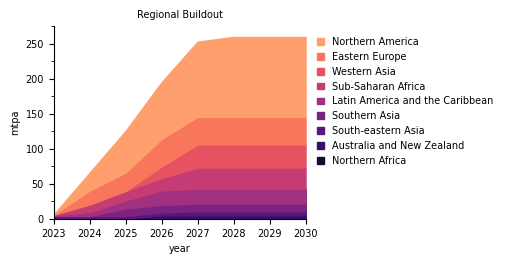

In [428]:
# fill up new capacities as they come online
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=subregion_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_americas = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('SubRegion')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
#eliminate all-zero columns
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

new_subregion_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.1,0.8,new_subregion_list.__len__())]

for subregion_idx in range(new_subregion_list.__len__()):
    if subregion_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[region_idx]],
                        color=region_colors[subregion_idx], 
                        label=new_subregion_list[subregion_idx])
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx]], 
                    color=region_colors[subregion_idx], 
                    label=new_subregion_list[subregion_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-subregional-export-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries.pdf', bbox_inches='tight', transparent=True)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries.svg', bbox_inches='tight', transparent=True)

In [429]:
mtpa_sum_regional_cumsum.loc[:,(mtpa_sum_regional_cumsum!= 0).any(axis=0)]

,Northern Africa,Australia and New Zealand,South-eastern Asia,Southern Asia,Latin America and the Caribbean,Sub-Saharan Africa,Western Asia,Eastern Europe,Northern America
2023,0.00,0.0,3.8,0.0,1.40,0.60,0.0,0.0,0.15
2024,0.07,0.0,3.8,0.0,5.50,11.12,0.0,19.7,25.54
2025,0.07,0.0,3.8,10.8,11.55,13.52,0.0,26.2,59.57
2026,0.07,5.0,3.8,10.8,20.95,17.62,16.5,39.3,81.05
2027,0.07,5.0,5.8,10.8,20.95,30.52,33.0,39.3,107.51
2028,0.07,5.0,5.8,10.8,20.95,30.52,33.0,39.3,114.26
2029,0.07,5.0,5.8,10.8,20.95,30.52,33.0,39.3,114.26
2030,0.07,5.0,5.8,10.8,20.95,30.52,33.0,39.3,114.26


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/1264861184.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/1264861184.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=matplotlib.cm.get_cmap('magma')(0.3),
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_15391/1264861184.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)

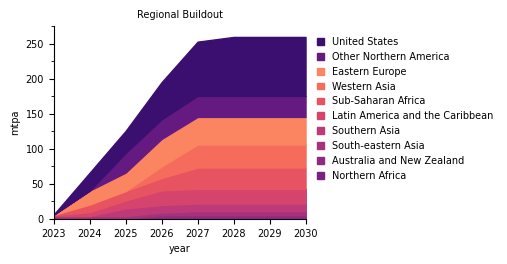

In [430]:
# fill up new capacities as they come online
start_year = 2023
end_year = 2030
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=subregion_list, index=year_list)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_const_fid_subset = terms_df_export_const_fid.loc[terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_export_const_fid_subset.groupby('SubRegion')['CapacityInMtpa'].sum()
    
    terms_df_export_subset_usa = terms_df_export_const_fid.loc[(terms_df_export_const_fid.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export_const_fid.Country=='United States')]
    
    mtpa_sum_usa[yr_idx:] += terms_df_export_subset_usa['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
#eliminate all-zero columns
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

mtpa_sum_rest_of_nam = mtpa_sum_regional_cumsum['Northern America'].values - mtpa_sum_usa

# ****************************************

font_size = 7
fig = mp.figure(figsize=(3.25,2.5))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,275)

new_subregion_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')#cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.35,0.8,new_subregion_list.__len__())]

for subregion_idx in range(new_subregion_list.__len__()):
    if subregion_idx==0:
        ax.fill_between(year_list, 
                        0, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[region_idx]],
                        color=region_colors[subregion_idx], 
                        label=new_subregion_list[subregion_idx])
    elif new_subregion_list[subregion_idx]=='Northern America':
            #pass
            #do the north america not USA chunk
            ax.fill_between(year_list, 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]], 
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam,
                        color=matplotlib.cm.get_cmap('magma')(0.3), 
                        label='Other Northern America')
            ax.fill_between(year_list,
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam,
                        mtpa_sum_regional_cumsum_byregion[new_subregion_list[-2]]+mtpa_sum_rest_of_nam+mtpa_sum_usa,
                        color=matplotlib.cm.get_cmap('magma')(0.2), 
                        label='United States')   
    else:
        ax.fill_between(year_list, 
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx-1]],
                    mtpa_sum_regional_cumsum_byregion[new_subregion_list[subregion_idx]], 
                    color=region_colors[subregion_idx], 
                    label=new_subregion_list[subregion_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_h[::-1],
          ax_l[::-1],
          fontsize=font_size, frameon=False, 
          handlelength=0.75, loc='upper left', bbox_to_anchor=(1.01,0.99))
ax.set_title('Regional Buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.pdf', bbox_inches='tight', transparent=True)
mp.savefig('saved-figures/mtpa-subregional-export-timeseries-usa.svg', bbox_inches='tight', transparent=True)

In [431]:
mtpa_sum_regional_cumsum_byregion

,Northern Africa,Australia and New Zealand,South-eastern Asia,Southern Asia,Latin America and the Caribbean,Sub-Saharan Africa,Western Asia,Eastern Europe,Northern America
2023,0.00,0.00,3.80,3.80,5.20,5.80,5.80,5.80,5.95
2024,0.07,0.07,3.87,3.87,9.37,20.49,20.49,40.19,65.73
2025,0.07,0.07,3.87,14.67,26.22,39.74,39.74,65.94,125.51
2026,0.07,5.07,8.87,19.67,40.62,58.24,74.74,114.04,195.09
2027,0.07,5.07,10.87,21.67,42.62,73.14,106.14,145.44,252.95
2028,0.07,5.07,10.87,21.67,42.62,73.14,106.14,145.44,259.70
2029,0.07,5.07,10.87,21.67,42.62,73.14,106.14,145.44,259.70
2030,0.07,5.07,10.87,21.67,42.62,73.14,106.14,145.44,259.70


In [432]:
pandas.DataFrame(numpy.column_stack((mtpa_sum_usa,mtpa_sum_rest_of_nam)), index=range(2023,2031), columns=['United States', 'Other Northern America'])

,United States,Other Northern America
2023,0.15,0.0
2024,25.54,0.0
2025,31.57,28.0
2026,53.05,28.0
2027,77.41,30.1
2028,84.16,30.1
2029,84.16,30.1
2030,84.16,30.1


# final read-through report number checks

In [433]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Operating']))&
                  (terms_df_orig.StartYear1.isin([2022,2023]))&
                  (terms_df_orig['FacilityType']=='Import')]['CapacityInMtpa'].sum()

124.31000000000002

In [434]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Operating']))&
                  (terms_df_orig.StartYear1.isin([2022,2023]))&
                  (terms_df_orig['FacilityType']=='Export')]['CapacityInMtpa'].sum()

16.46

In [435]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.Delayed=='Yes')]['CapacityInMtpa'].sum()

554.02

In [436]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Shelved']))]['CapacityInMtpa'].sum()

223.56

In [437]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Shelved']))&
                  (terms_df_orig.ShelvedYear.isin([2022,2023]))]['CapacityInMtpa'].sum()

98.31999999999998

In [438]:
terms_df_orig.loc[(terms_df_orig.Status.isin(['Cancelled']))&
                  (terms_df_orig.CancelledYear.isin([2022,2023]))]['CapacityInMtpa'].sum()

127.30000000000001

In [439]:
cost_by_country_export_df

Proposed  \
Region   SubRegion                       Country                               
Americas Northern America                United States          1.882702e+11   
Europe   Eastern Europe                  Russia                 1.524010e+11   
Americas Northern America                Canada                 5.736881e+10   
         Latin America and the Caribbean Mexico                 4.728523e+10   
Asia     Western Asia                    Qatar                  1.750000e+10   
Africa   Sub-Saharan Africa              Tanzania               4.200000e+10   
Oceania  Australia and New Zealand       Australia              2.843106e+10   
Africa   Sub-Saharan Africa              Mozambique             3.100820e+10   
Americas Latin America and the Caribbean Argentina              3.000000e+10   
Asia     South-eastern Asia              Indonesia              2.207254e+10   
Oceania  Melanesia                       Papua New Guinea       1.827069e+10   
Africa   Sub-Saharan Africa              Nigeria                1.135019e+10   
                                         Mauritania             1.024153e+10   
Asia     Southern Asia                   Iran                   0.000000e+00   
Africa   Sub-Saharan Africa              Senegal                6.791534e+09   
Asia     Western Asia                    United Arab Emirates   6.092458e+09   
Africa   Sub-Saharan Africa              Equatorial Guinea      4.488275e+09   
Asia     South-eastern Asia              Malaysia               3.358800e+09   
Americas Latin America and the Caribbean Suriname               2.021284e+09   
Africa   Sub-Saharan Africa              Republic of the Congo  0.000000e+00   
                                         Gabon                  1.000000e+09   
                                         Cameroon               5.000000e+08   
Asia     Western Asia                    Israel                 5.150000e+07   
Africa   Northern Africa                 Morocco                0.000000e+00   
Asia     Western Asia                    Yemen                  0.000000e+00   
Africa   Northern Africa                 Algeria                0.000000e+00   
Asia     Western Asia                    Cyprus                 0.000000e+00   
                                         Kuwait                 0.000000e+00   
                                         Oman                   0.000000e+00   
Europe   Northern Europe                 Norway                 0.000000e+00   
Africa   Northern Africa                 Egypt                  0.000000e+00   
                                         Libya                  0.000000e+00   
         Sub-Saharan Africa              Angola                 0.000000e+00   
                                         Djibouti               0.000000e+00   
Asia     South-eastern Asia              Brunei                 0.000000e+00   
Americas Latin America and the Caribbean Trinidad and Tobago    0.000000e+00   
                                         Venezuela              0.000000e+00   
                                         Brazil                 0.000000e+00   
Asia     Central Asia                    Turkmenistan           0.000000e+00   
Americas Latin America and the Caribbean Colombia               0.000000e+00   
                                         Peru                   0.000000e+00   
Total                                                           6.805033e+11   

                                                                Construction  \
Region   SubRegion                       Country                               
Americas Northern America                United States          5.937915e+10   
Europe   Eastern Europe                  Russia                 3.909304e+10   
Americas Northern America                Canada                 2.110000e+10   
         Latin America and the Caribbean Mexico                 3.733027e+09   
Asia     Western Asia                    Qatar                  2.8